In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time

In [2]:
def distance(a, b):
    return round(np.sqrt(( a[0] - b[0])**2 + (a[1]) - b[1])**2)

def calc_distance_sum(cycle, distance_matrix):
    suma = 0
    for i in range(1, len(cycle)):
        suma += distance_matrix[cycle[i-1], cycle[i]]
    return suma

In [42]:
def plot_results(cycles, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.show()

def plot_results2(cycles, cycles2, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')

    plt.plot(points_matrix[cycles2[1], 0], points_matrix[cycles2[1], 1], 'b')
    plt.plot(points_matrix[cycles2[0], 0], points_matrix[cycles2[0], 1], 'orange')

    plt.show()

def plot_results3(cycles, cycles2, points_matrix):
    ax, fig = plt.subplots(1, 3, figsize=(15, 5))
    fig[0].scatter(points_matrix[..., 0], points_matrix[..., 1])
    fig[0].plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    fig[0].plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')

    fig[1].scatter(points_matrix[..., 0], points_matrix[..., 1])
    fig[1].plot(points_matrix[cycles2[1], 0], points_matrix[cycles2[1], 1], 'b')
    fig[1].plot(points_matrix[cycles2[0], 0], points_matrix[cycles2[0], 1], 'orange')

    fig[2].scatter(points_matrix[..., 0], points_matrix[..., 1])
    fig[2].plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    fig[2].plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')
    fig[2].plot(points_matrix[cycles2[1], 0], points_matrix[cycles2[1], 1], 'b')
    fig[2].plot(points_matrix[cycles2[0], 0], points_matrix[cycles2[0], 1], 'orange')
    plt.show()

In [4]:
def solve_cycle(distance_matrix, start = -1):
    remaining = [i for i in range(distance_matrix.shape[0])]
    if start == -1:
        x = np.random.choice(remaining)
    else:
        x = start
    first_cycle = [x]
    remaining.remove(x)
    ind = np.argpartition(distance_matrix[x,:], -2)[-2:]
    second_x = ind.tolist()
    second_x.remove(x)
    second_x = second_x[0]
    second_cycle = [second_x]
    remaining.remove(second_x)

    cycles = [first_cycle, second_cycle]

    for cycle in cycles:
        min_node = remaining[np.argmin(distance_matrix[cycle[-1]][remaining])]
        cycle.append(min_node)
        remaining.remove(min_node)

    while remaining:
        for cycle in cycles:
            cycle.append(cycle[0])
            best_node = None
            lowest_distance_increase = np.inf
            best_index = None

            for i in range(len(cycle) - 1):
                for remaining_node in remaining:
                    distance_increase = distance_matrix[cycle[i]][remaining_node] + distance_matrix[remaining_node][cycle[i+1]] - distance_matrix[cycle[i]][cycle[i+1]]
                    if distance_increase < lowest_distance_increase:
                        lowest_distance_increase = distance_increase
                        best_node = remaining_node
                        best_index = i

            cycle.insert(best_index + 1, best_node)
            # plot_results(cycles)
            remaining.remove(best_node)
            cycle.pop()

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_random(distance_matrix):
    remaining = [i for i in range(distance_matrix.shape[0])]
    cycles = [[], []]
    append_to_cycle = 0
    while len(remaining) > 0:
        x = np.random.choice(remaining)
        cycles[append_to_cycle].append(x)
        remaining.remove(x)
        append_to_cycle = 1 - append_to_cycle

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

In [35]:
def shuffled_outside_swap_candidates(paths):
    arr = [[x,y] for x in range(len(paths[0])) for y in range(len(paths[1]))]
    random.shuffle(arr)
    return arr

def shuffled_inside_swap_candidates(path):
    arr = []
    for i in range(len(path)):
        for j in range(i+1, len(path) - 1):
            arr.append([i,j])
    random.shuffle(arr)
    return arr

def swap_vertice_cost(distance_matrix, path, index, new_city):
    path_length = len(path)
    previous = path[(index-1) % path_length]
    current = path[index]
    next = path[(index+1) % path_length]
    return distance_matrix[previous, new_city] + distance_matrix[new_city, next] - distance_matrix[previous, current] - distance_matrix[current, next]

def swap_vertice_outside_cost(distance_matrix, paths, i, j):
    return swap_vertice_cost(distance_matrix, paths[0], i, paths[1][j]) + swap_vertice_cost(distance_matrix, paths[1], j, paths[0][i])

def swap_vertice_inside_cost(distance_matrix, path, i, j): # can only use candidates from shuffled_inside_swap_candidates function
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    next1 = path[(i+1) % path_length]
    previous2 = path[(j-1) % path_length]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    if abs(i-j) == 1: # because if they are neighbours they can become each other next vertex in path, we also dont include distance between them in equation because it would be reduced anyway
        return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]
    if i in [0, path_length-1] and j in [0, path_length-1]:
        return distance_matrix[current2, next1] + distance_matrix[previous2, current1] - distance_matrix[current1, next1] - distance_matrix[previous2, current2]
    else:
        new_distance = distance_matrix[previous1, current2] + distance_matrix[current2, next1] + distance_matrix[previous2, current1] + distance_matrix[current1, next2]
        old_distance = distance_matrix[previous1, current1] + distance_matrix[current1, next1] + distance_matrix[previous2, current2] + distance_matrix[current2, next2]
        return new_distance - old_distance

def swap_edge_inside_cost(distance_matrix, path, i, j):
    if i == 0 and j == len(path) - 2:
        return 0
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]

def swap_vertice_outside(paths, i, j):
    k = paths[1][j]
    paths[1][j] = paths[0][i]
    paths[0][i] = k

def swap_vertice_inside(path, i, j):
    k = path[j]
    path[j] = path[i]
    path[i] = k

def swap_edges_inside(path, i, j):
    if i > j:
        i, j = j, i

    path[i:j+1] = reversed(path[i:j+1])

def solve_greedy(distance_matrix, initial_cycles, neighborhood='vertex'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()
    outside_checked = False
    inside_checked = False
    if neighborhood == 'vertex':
        while not (outside_checked and inside_checked):
            new_change_found = False
            if (not outside_checked and inside_checked) or (not outside_checked and np.random.random() < 0.5):
                outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
                for candidates in outside_swap_candidates:
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                    if delta < 0:
                        swap_vertice_outside(cycles, candidates[0], candidates[1])
                        new_change_found = True
                        break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                outside_checked = True
            if not inside_checked:
                order = np.arange(len(cycles))
                np.random.shuffle(order)
                for i in order:
                    inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                    for candidates in inside_swap_candidates:
                        delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                        if delta < 0:
                            swap_vertice_inside(cycles[i], candidates[0], candidates[1])
                            new_change_found = True
                            break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                inside_checked = True
    else:
        while not (outside_checked and inside_checked):
            new_change_found = False
            if (not outside_checked and inside_checked) or (not outside_checked and np.random.random() < 0.5):
                outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
                for candidates in outside_swap_candidates:
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                    if delta < -1e-7:
                        # print(f'outside swap {candidates[0]} {candidates[1]} {delta}')
                        swap_vertice_outside(cycles, candidates[0], candidates[1])
                        new_change_found = True
                        break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                outside_checked = True
            if not inside_checked:
                order = np.arange(len(cycles))
                np.random.shuffle(order)
                for i in order:
                    inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                    for candidates in inside_swap_candidates:
                        delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                        if delta < -1e-7:
                            # print(f'inside swap {i} {candidates[0]} {candidates[1]} {delta}')
                            swap_edges_inside(cycles[i], candidates[0], candidates[1])
                            new_change_found = True
                            break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                inside_checked = True

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_steepest(distance_matrix, initial_cycles, neighborhood='edge'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()

    new_change_found = True
    best_candidates = None
    is_change_outside = None
    best_cycle_index = 0
    if neighborhood == 'vertex':
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
            for candidates in outside_swap_candidates:
                delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_delta = delta
                    best_candidates = [candidates[0], candidates[1]]
                    is_change_outside = True
                    new_change_found = True

            for i in range(len(cycles)):
                inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                for candidates in inside_swap_candidates:
                    delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                    if delta < 0 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [candidates[0], candidates[1]]
                        best_cycle_index = i
                        is_change_outside = False
                        new_change_found = True

            if new_change_found:
                if is_change_outside:
                    swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
                else:
                    swap_vertice_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    else:
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
            for candidates in outside_swap_candidates:
                delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_delta = delta
                    best_candidates = [candidates[0], candidates[1]]
                    is_change_outside = True
                    new_change_found = True

            for i in range(len(cycles)):
                inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                for candidates in inside_swap_candidates:
                    delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                    if delta < 0 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [candidates[0], candidates[1]]
                        best_cycle_index = i
                        is_change_outside = False
                        new_change_found = True

            if new_change_found:
                if is_change_outside:
                    swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
                else:
                    swap_vertice_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

In [98]:

def swap_edge_inside_cost2(distance_matrix, path, i, j):
    if i > j:
        i, j = j, i
    delta1 = swap_edge_inside_cost(distance_matrix, path, (i+1) % len(path), j)
    delta2 = swap_edge_inside_cost(distance_matrix, path, i, (j-1) % len(path))
    if delta1 < delta2:
        return delta1, (i+1) % len(path), j
    else:
        return delta2, i, (j-1) % len(path)

def solve_cadidates(distance_matrix, initial_cycles, number_of_candidates=10):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()

    new_change_found = True
    while new_change_found:
        new_change_found = False
        best_candidates = None
        is_change_outside = None
        best_cycle_index = 0
        best_delta = np.inf
        for node in range(distance_matrix.shape[0]):
            node_cycle_index = 0 if node in cycles[0] else 1
            node_index = cycles[node_cycle_index].index(node)
            closest_nodes = np.argsort(distance_matrix[node])[1: number_of_candidates+1]
            for candidate in closest_nodes:
                candidate_cycle_index = 0 if candidate in cycles[0] else 1
                if node_cycle_index != candidate_cycle_index:
                    candidate_index = cycles[candidate_cycle_index].index(candidate)
                    if node_cycle_index == 0:
                        node_1, node_2 = node_index, candidate_index
                    else:
                        node_1, node_2 = candidate_index, node_index
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, node_1, node_2)
                    if delta < -1e-5 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [node_1, node_2]
                        is_change_outside = True
                        new_change_found = True
                else:
                    candidate_index = cycles[node_cycle_index].index(candidate)
                    if node_index < candidate_index:
                        node_1, node_2 = node_index, candidate_index
                    else:
                        node_1, node_2 = candidate_index, node_index
                    delta, node_1, node_2 = swap_edge_inside_cost2(distance_matrix, cycles[node_cycle_index], node_1, node_2)
                    if delta < -1e-5 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [node_1, node_2]
                        best_cycle_index = node_cycle_index
                        is_change_outside = False
                        new_change_found = True
        if new_change_found:
            # print(best_delta, best_candidates, is_change_outside)
            # print(best_candidates)
            if is_change_outside:
                swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
            else:
                swap_edges_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])
    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_msls(distance_matrix, local_search, number_of_iterations=100):
    best_distance = np.inf
    best_cycles = None
    for i in range(number_of_iterations):
        print(f'Iteration {i}')
        starting_cycles = solve_random(distance_matrix)
        cycles = local_search(distance_matrix, starting_cycles, neighborhood='edges')
        distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
        if distance < best_distance:
            best_distance = distance
            best_cycles = copy.deepcopy(cycles)
    return best_cycles


def apply_perturbation(cycles, distance_matrix):
    if np.random.rand() < 0.5:
        # swap two vertices between cycles
        cycle_1 = np.random.randint(2)
        cycle_2 = 1 - cycle_1
        vertice_1 = np.random.randint(len(cycles[cycle_1]))
        vertice_2 = np.random.randint(len(cycles[cycle_2]))
        swap_vertice_outside(cycles, vertice_1, vertice_2)
    else:
        # swap two vertices inside one cycle
        cycle = np.random.randint(2)
        vertice_1 = np.random.randint(len(cycles[cycle]))
        vertice_2 = np.random.randint(len(cycles[cycle]))
        swap_vertice_inside(cycles[cycle], vertice_1, vertice_2)
    return cycles


def solve_ils1(distance_matrix, local_search, number_of_perturbations, time_limit, points_matrix):
    time_remaining = time_limit
    start_time = time.time()
    starting_cycles = solve_random(distance_matrix)
    cycles = local_search(distance_matrix, starting_cycles, neighborhood='edges')
    # plot_results(cycles, points_matrix)
    best_distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
    best_cycles = copy.deepcopy(cycles)
    while time_remaining > 0:
        # print(f'time remaining {time_remaining}')
        # cycles_copy = copy.deepcopy(cycles)
        for _ in range(number_of_perturbations):
            cycles = apply_perturbation(cycles, distance_matrix)
        # plot_results3(cycles_copy, cycles, points_matrix)
        cycles = local_search(distance_matrix, cycles, neighborhood='edges')
        distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
        if distance < best_distance:
            best_distance = distance
            best_cycles = copy.deepcopy(cycles)
        time_remaining = time_limit - (time.time() - start_time)
    return best_cycles


In [35]:
# instances = ['./data/lab1/kroA100.txt', './data/lab1/kroB100.txt']
instances = ['./data/lab3/kroA200.txt', './data/lab3/kroB200.txt']
instance_size = 200
strategies = [solve_msls]

def get_results_msls():
    results = []
    times = []
    for instance in instances:
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(instance_size, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(instance_size):
            matrix.append([])
            for j in range(instance_size):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        for strategy in strategies:
            distances = []
            algorithm_times = []
            best_cycles = None
            best_distance = np.inf
            # for i in range(distance_matrix.shape[0]):
            for i in range(10):
                print(f'Intance: {instance}, strategy: {strategy.__name__}, node: {i}')
                start_time = time.time()
                cycles = strategy(distance_matrix, solve_greedy, number_of_iterations=100)
                algorithm_times.append(time.time() - start_time)
                distances.append(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
                if distances[-1] < best_distance:
                    best_distance = distances[-1]
                    best_cycles = copy.deepcopy(cycles)
            times.append(dict(instance=instance, strategy=strategy.__name__, min_time=min(algorithm_times), mean_time=np.mean(algorithm_times), max_time=max(algorithm_times)))
            results.append(dict(instance=instance, strategy=strategy.__name__, min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
            print(f'Intance: {instance}, strategy: {strategy.__name__}, best_distance: {best_distance}')
            plot_results(best_cycles, points_matrix)
    return results, times

Intance: ./data/lab3/kroA200.txt, strategy: solve_msls, node: 0
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 

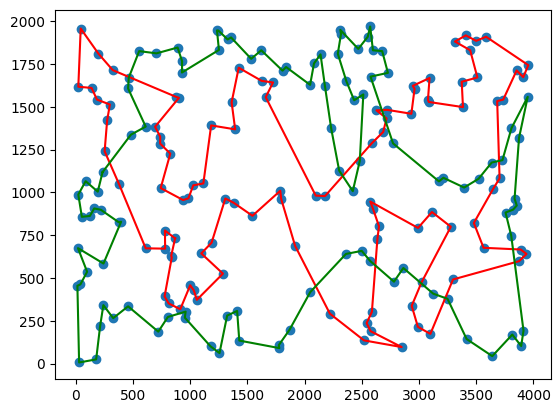

Intance: ./data/lab3/kroB200.txt, strategy: solve_msls, node: 0
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 

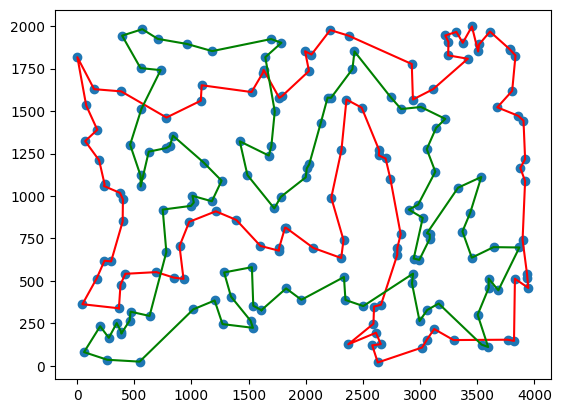

In [36]:
results_msls, times_msls = get_results_msls()

In [37]:
pd.DataFrame(results_msls)

,instance,strategy,min_distance,mean_distance,max_distance
0,./data/lab3/kroA200.txt,solve_msls,35498.673943,36006.531427,36847.047220
1,./data/lab3/kroB200.txt,solve_msls,35491.588385,36122.882108,36525.033127


In [38]:
pd.DataFrame(times_msls)

,instance,strategy,min_time,mean_time,max_time
0,./data/lab3/kroA200.txt,solve_msls,403.983396,411.651582,432.836930
1,./data/lab3/kroB200.txt,solve_msls,403.087712,409.593272,413.608258


In [108]:
# instances = ['./data/lab1/kroA100.txt', './data/lab1/kroB100.txt']
instances = ['./data/lab3/kroA200.txt', './data/lab3/kroB200.txt']
# instances = ['./data/lab3/kroA200.txt']
instance_size = 200
strategies = [solve_ils1]

def get_results():
    results = []
    times = []
    for instance in instances:
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(instance_size, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(instance_size):
            matrix.append([])
            for j in range(instance_size):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        for strategy in strategies:
            distances = []
            algorithm_times = []
            best_cycles = None
            best_distance = np.inf
            # for i in range(distance_matrix.shape[0]):
            for i in range(10):
                print(f'Intance: {instance}, strategy: {strategy.__name__}, node: {i}')
                start_time = time.time()
                cycles = strategy(distance_matrix, solve_greedy, 10, 411.651582, points_matrix)
                algorithm_times.append(time.time() - start_time)
                distances.append(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
                if distances[-1] < best_distance:
                    best_distance = distances[-1]
                    best_cycles = copy.deepcopy(cycles)
            times.append(dict(instance=instance, strategy=strategy.__name__, min_time=min(algorithm_times), mean_time=np.mean(algorithm_times), max_time=max(algorithm_times)))
            results.append(dict(instance=instance, strategy=strategy.__name__, min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
            print(f'Intance: {instance}, strategy: {strategy.__name__}, best_distance: {best_distance}')
            plot_results(best_cycles, points_matrix)
    return results, times

In [ ]:
results_ils1, times_ils1 = get_results()

Intance: ./data/lab3/kroA200.txt, strategy: solve_ils1, node: 0


In [107]:
pd.DataFrame(results_ils1)

,instance,strategy,min_distance,mean_distance,max_distance
0,./data/lab3/kroA200.txt,solve_ils1,35309.479228,37515.924416,38714.274118
1,./data/lab3/kroB200.txt,solve_ils1,36191.756370,37264.167739,39193.527555
